# Conducting Physical Analysis Between Region

Here we conduct physical analysis between basins.

1) We download a handful of floats into a parquet and estimate potential density and calculate MLD

2) Expansion into a larger dataset, Here we expand nº1 into a larger dataset and seperating into regions

# Downloading Handful of floats

Downloading speific floats and estiamte physical parameters

In [47]:
# Libraries for data handling

import polars as pl
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Library for estimating oceanographic parameters
import gsw

# Library for donwloading data

import os
from pathlib import Path
import argopy
from argopy import DataFetcher

## Downloading Floats 

In [27]:
# Base filepath
root = '../data/argo/'
profile_dir = root + 'Profiles/'

# Create GO-BGC folders if they do not exist yet
if 'argo' not in os.listdir('../data/'):
  os.mkdir(root)
if 'Profiles' not in os.listdir(root):
  os.mkdir(profile_dir)

# Downloading data using argopy
float_ids = [6903871, 6902882, 6902802, 6901627, 6902807, 6901601, 6901029]  # Ice Shelf and Open Ocean Floats

# Fetching data
ds = DataFetcher(src ='gdac', 
                 mode = 'standard').float(
                     float_ids).to_xarray()

# Quality Control Filtering
ds = ds.argo.filter_qc(QC_list=[1,2])  # Keep only good and probably good data

# Downloading data using argopy

ds = ds.to_dataframe().reset_index()
ds = pl.from_pandas(ds)

# Saving in one dataset parquet
out_path = Path(profile_dir)/ f"Grouped_data_set.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

ds.write_parquet(out_path)
print(f"Saved all float in one parquet -> {profile_dir}")

# Saving by Float number
#for fid in float_ids:
#    sub = ds.filter(pl.col("PLATFORM_NUMBER") == fid)
#    out_path = Path(profile_dir)/ f"{fid}.parquet"
#    out_path.parent.mkdir(parents=True, exist_ok=True)
#    sub.write_parquet(out_path)
#    print(f"Saved float {fid} -> {profile_dir}")


Saved all float in one parquet -> ../data/argo/Profiles/


## Comparing Basins

Creating Function:

1) density Calcl
2) Sigma0 Potential density
3) Estimating Mixlayer depth using the density threshold of ~0.3

In [48]:
# Defining Function

"""
  In site density Calculation Function.
Using Gibbs SeaWater (GSW) Oceanographic Toolbox, it is added as 
another column to the Polars DataFrame.
"""
def add_density(df: pl.DataFrame) -> pl.DataFrame:
    # Extract numpy arrays
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    # Compute absolute salinity, conservative temperature, density
    SA  = gsw.SA_from_SP(SP, p, lon, lat)
    CT  = gsw.CT_from_t(SA, t, p)
    rho = gsw.rho(SA, CT, p)

    # Append new column as a Polars Series
    return df.with_columns(pl.Series("RHO", rho))

# Creating potential density function (for MLD calculations)
def add_sigma0(df: pl.DataFrame) -> pl.DataFrame:
    """
    Add potential density anomaly sigma0 [kg/m^3 - 1000] as a column 'SIGMA0'.
    Requires PSAL [PSS-78], TEMP [°C in-situ], PRES [dbar], LONGITUDE [degE], LATITUDE [degN].
    """
    SP  = df["PSAL"].to_numpy()
    t   = df["TEMP"].to_numpy()
    p   = df["PRES"].to_numpy()
    lon = df["LONGITUDE"].to_numpy()
    lat = df["LATITUDE"].to_numpy()

    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_t(SA, t, p)
    sigma0 = gsw.sigma0(SA, CT)  # kg/m^3 - 1000
    return df.with_columns(pl.Series("SIGMA0", sigma0))

# Creating Mixed Layer Depth function for MLD calculations
"""
 Calculation based on de Montety et al. (2014) definition:
"""
# Compute MLD per profile
def compute_mld_for_profile(pres: np.ndarray, sigma0: np.ndarray,
                            ref_depth: float = 10.0, drho_threshold: float = 0.03) -> float:
    sort_idx = np.argsort(pres)
    pres_sorted = pres[sort_idx]
    sigma0_sorted = sigma0[sort_idx]
    idx_ref = np.argmin(np.abs(pres_sorted - ref_depth))
    sigma0_ref = sigma0_sorted[idx_ref]
    sigma0_th = sigma0_ref + drho_threshold
    mask = sigma0_sorted >= sigma0_th
    mask[:(idx_ref+1)] = False
    if not np.any(mask):
        return np.nan
    idx_mld = np.where(mask)[0][0]
    return float(pres_sorted[idx_mld])





In [49]:
# Loading data 
df = pl.read_parquet('../data/argo/profiles/Grouped_data_set.parquet')

# Filtering data below 500m
df = df.filter(pl.col('PRES') < 500)

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()




N_POINTS,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ERROR,PRES_QC,PSAL,PSAL_ERROR,PSAL_QC,TEMP,TEMP_ERROR,TEMP_QC,TIME_QC,TIME,LATITUDE,LONGITUDE,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,i64,f32,f32,i64,f32,f32,i64,i64,datetime[ns],f64,f64,f64,f64
0,1,"""D""","""D""",6901029,1,17.0,2.4,1,34.799999,0.01,1,11.131,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,26.600054,17.0
1,1,"""D""","""D""",6901029,1,24.0,2.4,1,34.882,0.01,1,8.478,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.111274,17.0
2,1,"""D""","""D""",6901029,1,34.0,2.4,1,34.872002,0.01,1,6.765,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.352959,17.0
3,1,"""D""","""D""",6901029,1,45.0,2.4,1,34.865002,0.01,1,6.177,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.425852,17.0
4,1,"""D""","""D""",6901029,1,55.0,2.4,1,34.896,0.01,1,5.682,0.002,1,1,2012-07-15 02:19:00.000000256,59.368,-36.388,27.513338,17.0


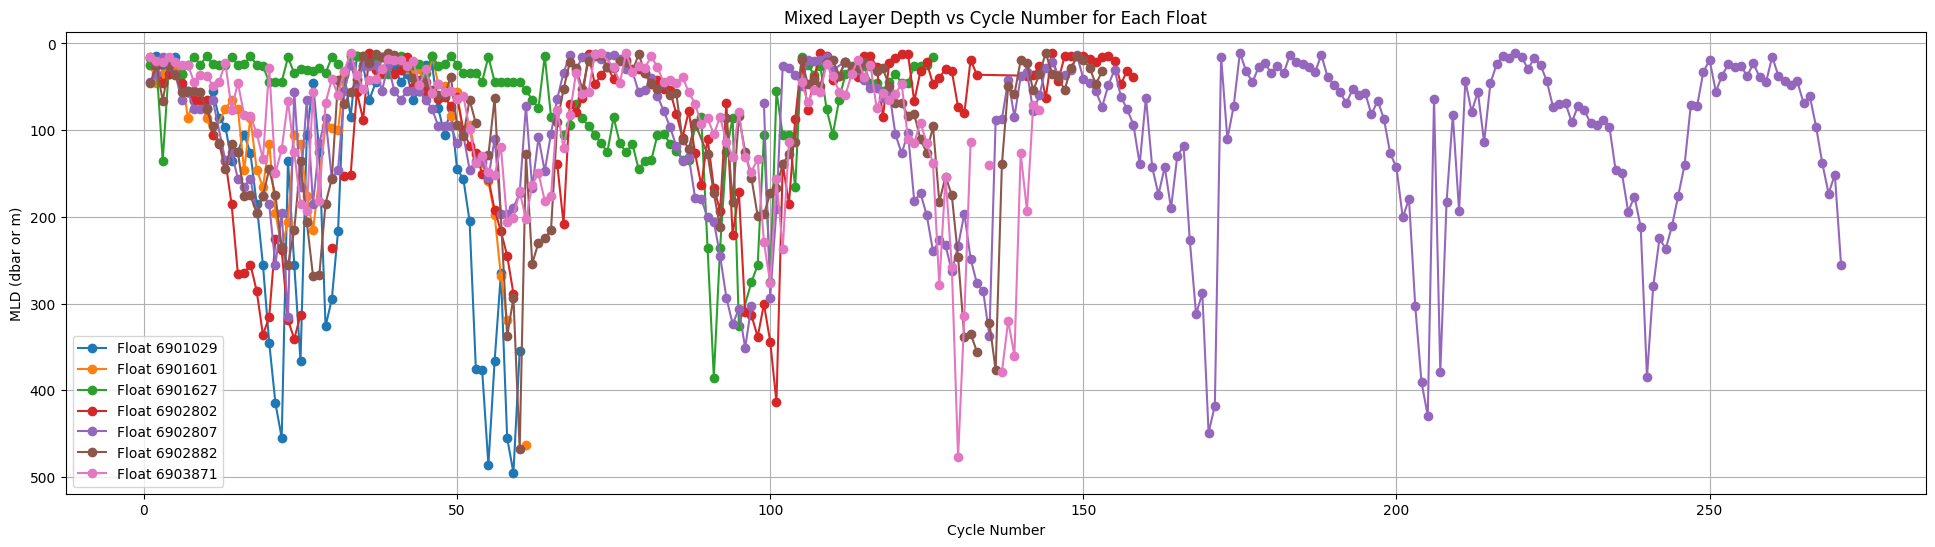

In [50]:
# Plotting df

cycle_summary = (df.
                 select("PLATFORM_NUMBER", "CYCLE_NUMBER", "MLD")
                 .unique()
                 .sort("PLATFORM_NUMBER", "CYCLE_NUMBER"))

summary_pd = cycle_summary.to_pandas()


fig, ax = plt.subplots(figsize=(24,6))
for float_id, sub in summary_pd.groupby("PLATFORM_NUMBER"):
    ax.plot(sub["CYCLE_NUMBER"], sub["MLD"],
            marker="o", label=f"Float {float_id}")

ax.set_xlabel("Cycle Number")
ax.set_ylabel("MLD (dbar or m)")
ax.set_title("Mixed Layer Depth vs Cycle Number for Each Float")
ax.invert_yaxis()  # optional: deeper = larger depth, so invert if you want shallow at top
ax.legend()
plt.grid(True)
plt.show()

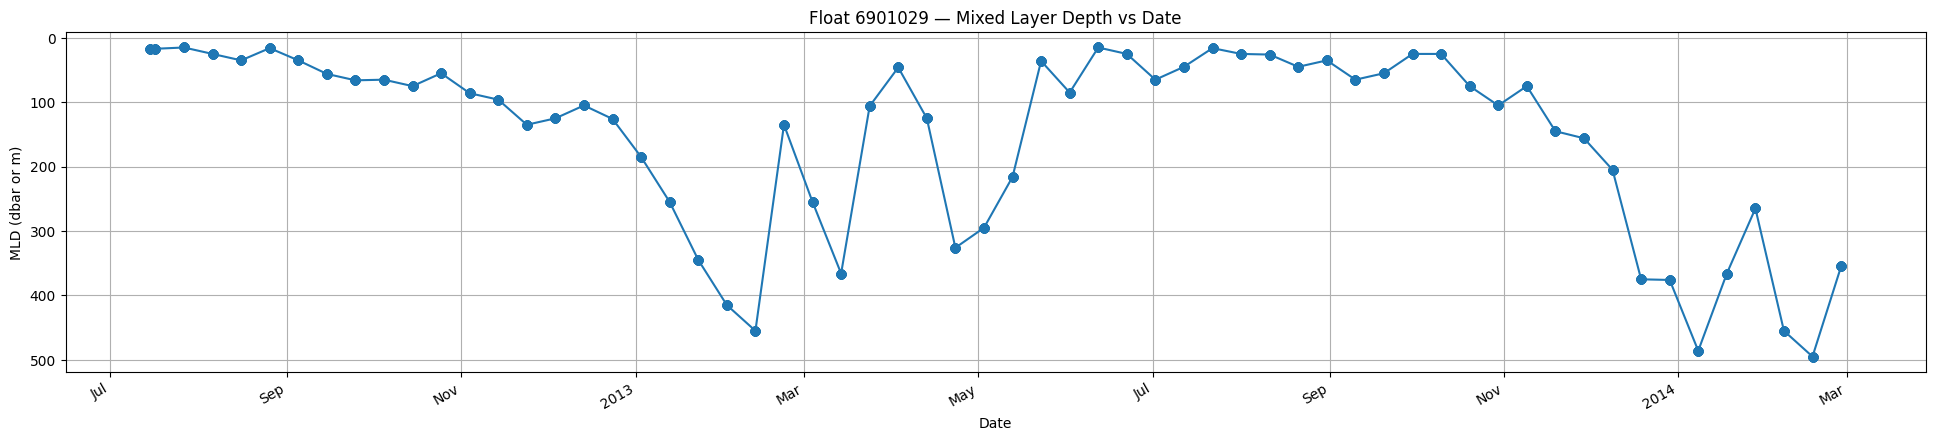

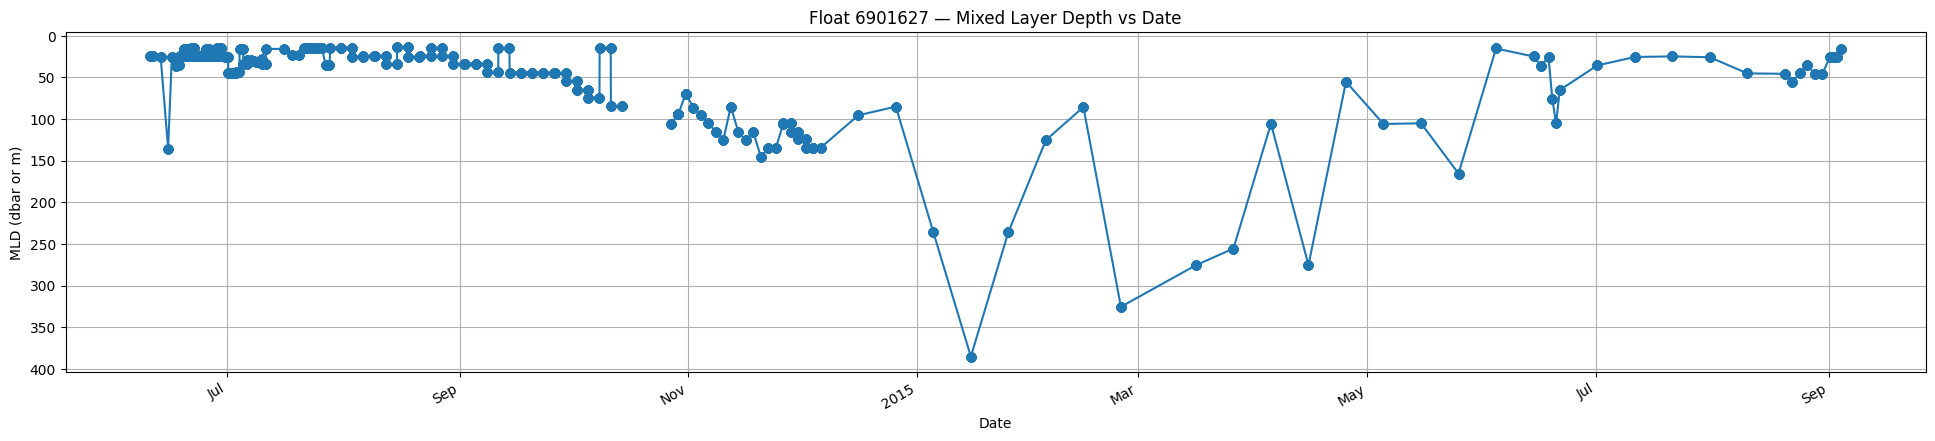

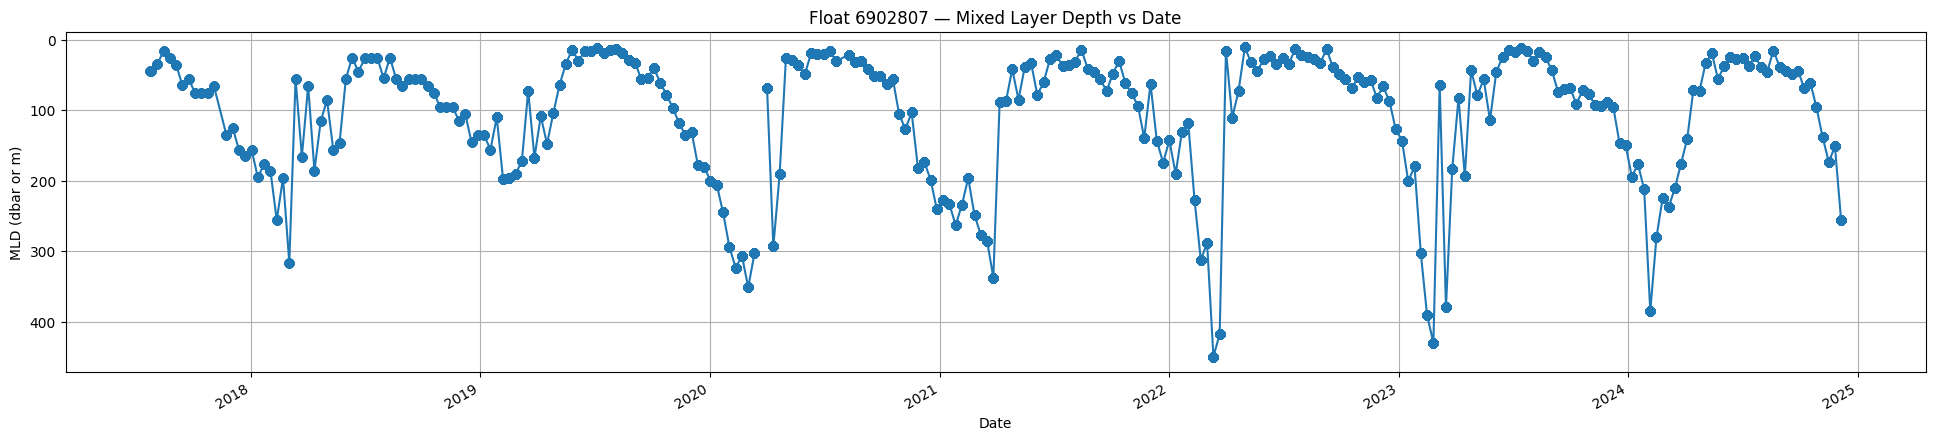

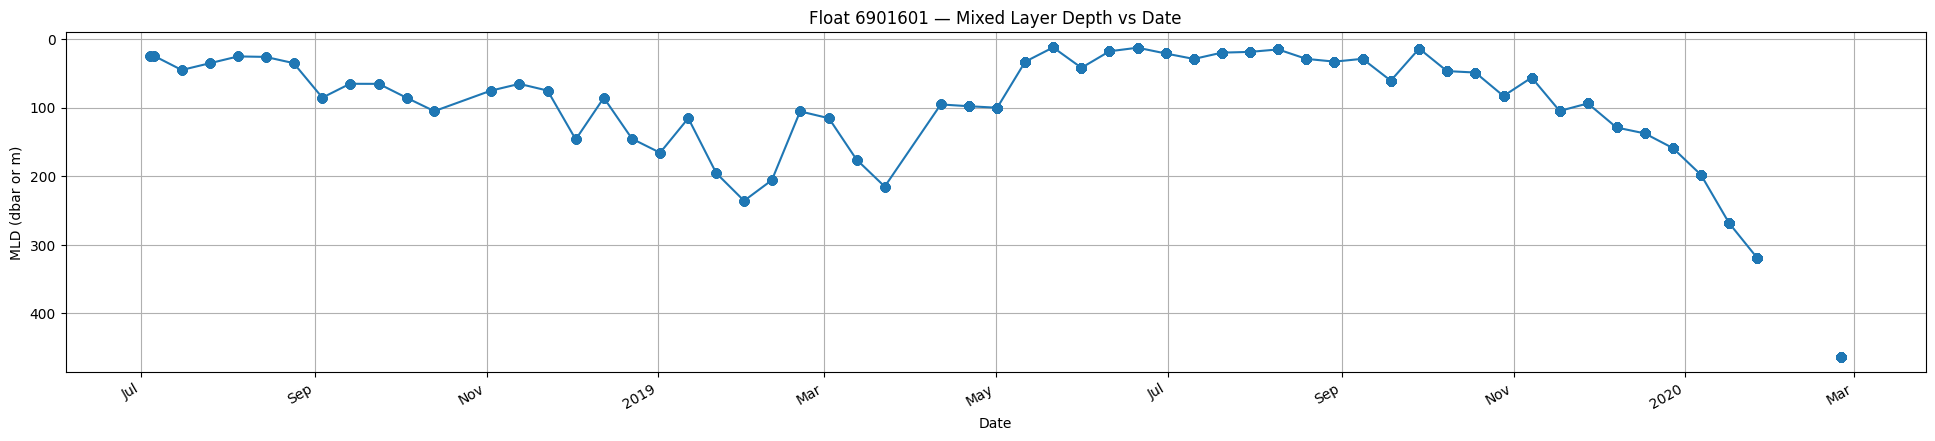

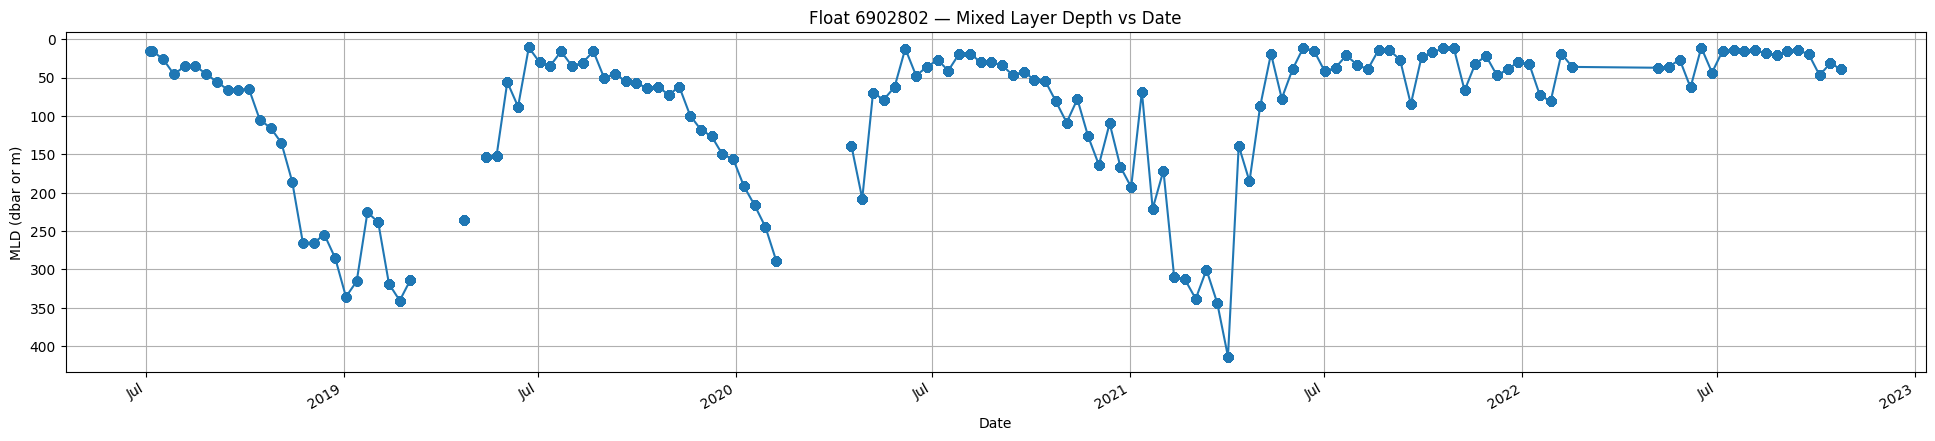

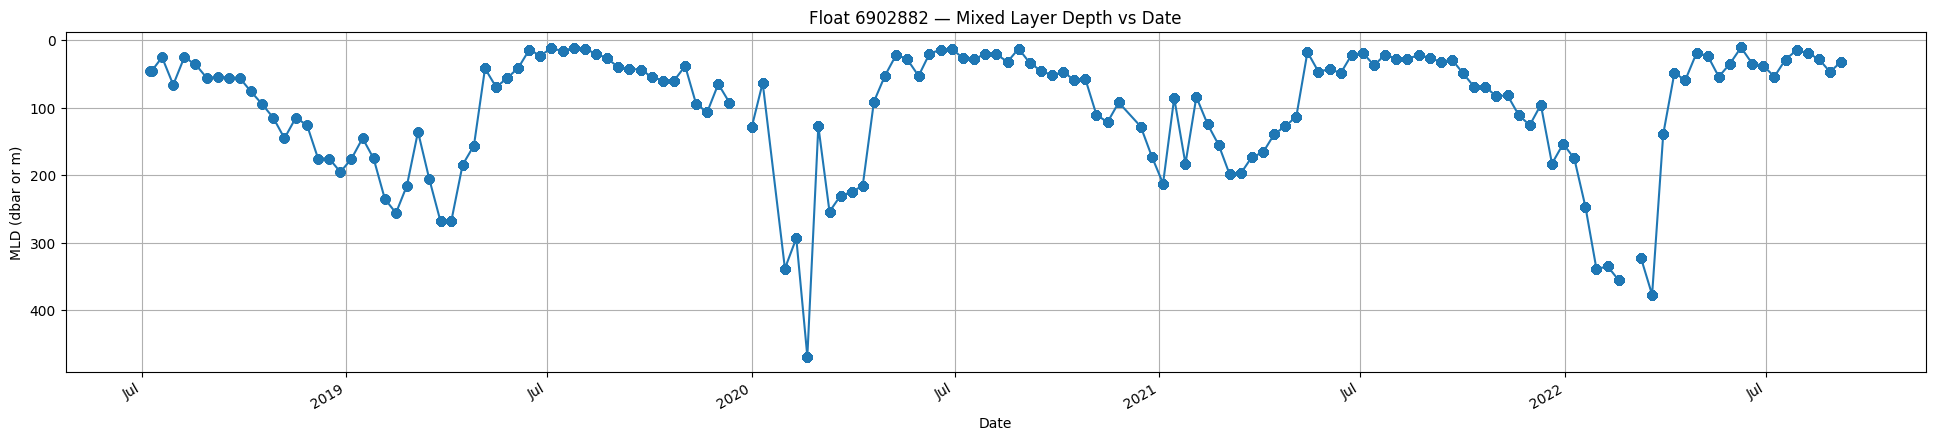

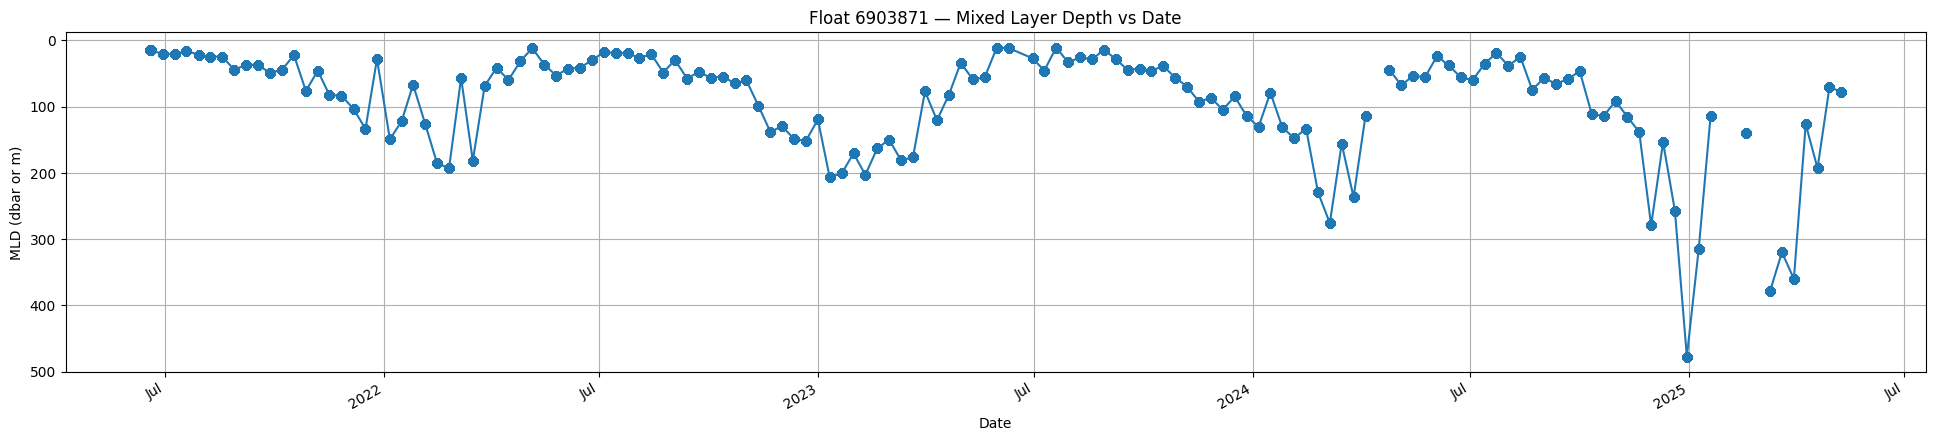

In [51]:
pd_df = df.to_pandas()

# Make sure your date column is a proper datetime
# Example: if your column is 'JULD', convert like:
pd_df['TIME'] = pd.to_datetime(pd_df['TIME'])

# Filter by each float and plot
for fid in pd_df['PLATFORM_NUMBER'].unique():
    sub = pd_df[pd_df['PLATFORM_NUMBER'] == fid]
    # Summarise one MLD per cycle (assuming one MLD per cycle)
    summary = sub.groupby('CYCLE_NUMBER').agg({
        'TIME': 'first',   # or maybe 'min' or 'max' depending
        'MLD': 'first'
    }).reset_index()

    fig, ax = plt.subplots(figsize=(24,5))
    ax.plot(sub['TIME'], sub["MLD"],
            marker="o", label=f"Float {float_id}")
    ax.set_title(f"Float {fid} — Mixed Layer Depth vs Date")
    ax.set_xlabel("Date")
    ax.set_ylabel("MLD (dbar or m)")
    ax.invert_yaxis()  # deeper depth = larger number → put deeper downwards
    # Format the x-axis as dates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate()
    plt.grid(True)
    plt.show()

# Expanding into Larger dataset

## Import and set-up

In [19]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [20]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

### Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [21]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-36, -10, 55, 67, 0, 3000, '2015-01', '2024-12']

### Get more info about this region using the ArgoIndex

In [22]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (365694 records)
Searched: False

In [23]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [24]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [25]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
#[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM']]  # Remove core variables from the list
bgc_params

['BBP532',
 'BBP700',
 'BISULFIDE',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'DOXY2',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [26]:
# How many different floats in the region:
len(idx.read_wmo())

80

### Load all data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [27]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 4min 4s, sys: 26.1 s, total: 4min 31s
Wall time: 14min 18s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo data fetcher for a space/time region
🗺  Domain: [x=-36.00/-10.00; y=55.00/67.00; z=0.0/3000.0; t=2015-01-01/2024-12-01]
🔗 API: https://erddap.ifremer.fr/erddap
🏄 User mode: expert
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [thread]

In [28]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 6GB
Dimensions:                   (N_POINTS: 5493656)
Coordinates:
    LATITUDE                  (N_POINTS) float64 44MB 59.52 59.52 ... 60.37
    LONGITUDE                 (N_POINTS) float64 44MB -25.61 -25.61 ... -20.53
    TIME                      (N_POINTS) datetime64[ns] 44MB 2015-01-01T13:32...
  * N_POINTS                  (N_POINTS) int64 44MB 0 1 2 ... 5493654 5493655
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 44MB 14 14 14 14 14 ... 2 2 2 2 2
    CYCLE_NUMBER              (N_POINTS) int64 44MB 64 64 64 64 ... 127 127 127
    DATA_MODE                 (N_POINTS) <U1 22MB 'D' 'D' 'D' ... 'D' 'D' 'D'
    DIRECTION                 (N_POINTS) <U1 22MB 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 44MB 6901647 6901647 ... 6903871
    POSITION_QC               (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 22MB 7.775 7.775 ... 2.711
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 22MB 0.002 0.002 ... 0.002
    TEMP_ADJUSTED_QC          (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TEMP_QC                   (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 2 2 2 2 2 2
    TIME_QC                   (N_POINTS) int64 44MB 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U246 5GB 'Primary sampling: average...
Attributes: (7)

In [29]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(5493656) ~ N_PROF(17945) x N_LEVELS(3989)

In [30]:
import polars as pl
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [31]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/Region/'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'Region' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

In [32]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2024-06-28 12:57:59,60.078591,-20.071637,6990636,12
1,2024-06-25 00:47:22,60.153341,-21.595969,6990636,11
2,2024-06-22 12:51:02,59.830355,-21.894241,6990636,10
3,2024-06-19 00:44:28,59.556890,-21.006004,6990636,9
4,2024-06-16 12:49:22,59.614345,-20.229507,6990636,8
...,...,...,...,...,...
17940,2024-10-12 11:40:57,62.139584,-23.308234,7902223,14
17941,2024-10-22 11:33:27,61.999185,-24.537202,7902223,15
17942,2024-11-01 11:38:57,62.179831,-23.975721,7902223,16
17943,2024-11-11 11:38:58,62.581411,-23.856008,7902223,17


In [33]:
df = pl.read_parquet('../data/argo/Region/Regional_Argo_Tablet.parquet')

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns]
14,64,"""D""","""A""",6901647,1,5.1,5.1,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,5.7,5.7,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,6.4,6.4,2.4,1,1,35.083,35.134998,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,7.5,7.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.774,7.774,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00
14,64,"""D""","""A""",6901647,1,8.5,8.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.773,7.773,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00


## Creating Polygone Mask 

Creating polygons to produce a polygone mask to seperate dataset

In [35]:
# CHAT GPT need to re-assess this section

# --- 0) config ---
raster_path = "../data/etopo1_subset.nc"
profiles_parquet = "../data/argo/Region/Regional_Argo_Tablet.parquet"          # <-- change if needed
out_parquet = "../data/argo/Region/profiles_with_regions.parquet"  # <-- change if needed
require_deep_ocean = True  # set True if you want to keep only z <= -1000 m

# --- 1) load ETOPO1 (optional, for deep-ocean mask) ---
ds = xr.open_dataset(raster_path)
# Common ETOPO1 names: z (meters), longitude, latitude
z_da = ds["z"]
lon_grid = ds["longitude"]
lat_grid = ds["latitude"]

# helper: normalize lon to [-180, 180]
def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0

# --- 2) load your BGC profiles ---
df = pd.read_parquet(profiles_parquet)
# assume df has columns: 'longitude', 'latitude'
lonp = to_minus180_180(df["LONGITUDE"].values)
latp = df["LATITUDE"].values

# --- 3) define the two shapes as inequalities on points ---

# Shape 1: "Ismingter Basin" (using your formulas)
# bounds: -35 <= lon <= -25, lat_min <= lat <= 66, where
# lat_min = 56 + 0.8*(lon + 35)
lat_min_1 = 56.0 + 0.8*(lonp + 35.0)
in_shape1 = (lonp >= -35.0) & (lonp <= -25.0) & (latp >= lat_min_1) & (latp <= 66.0)

# Shape 2: "Icelanding Basin" (piecewise top/bottom)
# domain: -34 <= lon <= -10
# upper:
#   if lon <= -25: lat_upper = lon + 89
#   else:          lat_upper = 64
lat_upper_2 = np.where(lonp <= -25.0, lonp + 89.0, 64.0)
# lower:
#   if lon <= -22: lat_lower = 55
#   else:          lat_lower = 66 + 0.5*lon
lat_lower_2 = np.where(lonp <= -22.0, 55.0, 66.0 + 0.5*lonp)
in_shape2 = (lonp >= -34.0) & (lonp <= -10.0) & (latp >= lat_lower_2) & (latp <= lat_upper_2)

# --- 4) optional: enforce deep ocean (z <= -1000 m) at the profile points ---
if require_deep_ocean:
    # Build indexers for interpolation
    # Note: ETOPO1 often uses coords named exactly 'longitude'/'latitude'
    zi = z_da.interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    deep = zi <= -1000.0
    in_shape1 &= deep
    in_shape2 &= deep

# --- 5) label rows ---
labels = np.full(len(df), "Other", dtype=object)
labels[in_shape1] = "shape1"
labels[in_shape2] = "shape2"

# If you want exactly-one region (shape2 overrides shape1 where they overlap),
# the above already does that due to evaluation order. If you want the reverse,
# assign shape2 first, then shape1.

df["region"] = labels

# (optional) if you want to keep only the two shapes:
# df = df[df["region"].isin(["shape1", "shape2"])].reset_index(drop=True)

# --- 6) save ---
df.to_parquet(out_parquet, index=False)
print(df["region"].value_counts(dropna=False))
print(f"Saved: {out_parquet}")
print(df["region"].value_counts())

region
Other    5493656
Name: count, dtype: int64
Saved: ../data/argo/Region/profiles_with_regions.parquet
region
Other    5493656
Name: count, dtype: int64


In [43]:
## Need to re-asses this section
# Load
parquet_path = "../data/argo/Region/profiles_with_regions.parquet"   # or your input parquet
df = pd.read_parquet(parquet_path).copy()

# Make sure the column names match yours:
LON = df["LONGITUDE"].astype(float).to_numpy()
LAT = df["LATITUDE"].astype(float).to_numpy()


# 0) Sanity checks
print("Lon range:", np.nanmin(LON), "→", np.nanmax(LON))
print("Lat range:", np.nanmin(LAT), "→", np.nanmax(LAT))
print("N rows:", len(df))

# 1) Shape 1 – break it into parts
lon_ok_1 = (LON >= -35.0) & (LON <= -25.0)
lat_min_1 = 56.0 + 0.8*(LON + 35.0)          # diagonal lower boundary
lat_low_ok_1 = LAT >= lat_min_1
lat_high_ok_1 = LAT <= 66.0
in_shape1 = lon_ok_1 & lat_low_ok_1 & lat_high_ok_1

print("\n--- Shape 1 ---")
print("lon_ok_1:", lon_ok_1.sum())
print("lat_low_ok_1:", lat_low_ok_1.sum())
print("lat_high_ok_1:", lat_high_ok_1.sum())
print("in_shape1 total:", in_shape1.sum())

# 2) Shape 2 – also broken into parts
lon_ok_2 = (LON >= -34.0) & (LON <= -10.0)
lat_upper_2 = np.where(LON <= -25.0, LON + 89.0, 64.0)
lat_lower_2 = np.where(LON <= -22.0, 55.0, 66.0 + 0.5*LON)

lat_low_ok_2  = LAT >= lat_lower_2
lat_high_ok_2 = LAT <= lat_upper_2
in_shape2 = lon_ok_2 & lat_low_ok_2 & lat_high_ok_2

print("\n--- Shape 2 ---")
print("lon_ok_2:", lon_ok_2.sum())
print("lat_low_ok_2:", lat_low_ok_2.sum())
print("lat_high_ok_2:", lat_high_ok_2.sum())
print("in_shape2 total:", in_shape2.sum())

# 3) Inspect a few candidates close to each shape’s bbox (helps catch off-by-sign issues)
near_bbox1 = df[lon_ok_1].head(10)[["LONGITUDE","LATITUDE"]]
near_bbox2 = df[lon_ok_2].head(10)[["LONGITUDE","LATITUDE"]]
print("\nExamples near Shape1 lon-range:\n", near_bbox1)
print("\nExamples near Shape2 lon-range:\n", near_bbox2)

# 4) (Re)label with explicit precedence (shape2 overrides shape1; change order if you prefer)
labels = np.full(len(df), "Other", dtype=object)
labels[in_shape1] = "shape1"
labels[in_shape2] = "shape2"   # override where both true
df["region_debug"] = labels

print("\nCounts:")
print(pd.Series(labels).value_counts(dropna=False))


Lon range: -35.99964666666666 → -10.002
Lat range: 55.0013 → 66.99883
N rows: 5493656

--- Shape 1 ---
lon_ok_1: 3151954
lat_low_ok_1: 2082596
lat_high_ok_1: 5415752
in_shape1 total: 1796307

--- Shape 2 ---
lon_ok_2: 4867198
lat_low_ok_2: 5029119
lat_high_ok_2: 3007724
in_shape2 total: 2543187

Examples near Shape1 lon-range:
    LONGITUDE   LATITUDE
0 -25.608217  59.523875
1 -25.608217  59.523875
2 -25.608217  59.523875
3 -25.608217  59.523875
4 -25.608217  59.523875
5 -25.608217  59.523875
6 -25.608217  59.523875
7 -25.608217  59.523875
8 -25.608217  59.523875
9 -25.608217  59.523875

Examples near Shape2 lon-range:
    LONGITUDE   LATITUDE
0 -25.608217  59.523875
1 -25.608217  59.523875
2 -25.608217  59.523875
3 -25.608217  59.523875
4 -25.608217  59.523875
5 -25.608217  59.523875
6 -25.608217  59.523875
7 -25.608217  59.523875
8 -25.608217  59.523875
9 -25.608217  59.523875

Counts:
shape2    2543187
shape1    1796307
Other     1154162
Name: count, dtype: int64


## Comparing Basins

Comparing Basins using larger dataset

In [ ]:
# Fetching data from Parquet.

df = pl.read_parquet('../data/argo/Region/profiles_with_regions.parquet')


# Filtering data below 500m
df = df.filter(pl.col('PRES') < 1000)

# EStimating MLD

# Applying potential density Density calc Function
df = add_sigma0(df)

# Groupin and computing MLD per profile 
summary_mld = (
    df.group_by("PLATFORM_NUMBER", "CYCLE_NUMBER")
      .map_groups(lambda group: pl.DataFrame({
            "PLATFORM_NUMBER": [group["PLATFORM_NUMBER"].to_list()[0]],
            "CYCLE_NUMBER": [group["CYCLE_NUMBER"].to_list()[0]],
            "MLD": [
              compute_mld_for_profile(
                pres=group["PRES"].to_numpy(),
                sigma0=group["SIGMA0"].to_numpy(),
                ref_depth=10.0,
                drho_threshold=0.03
              )
            ]
        }))
)

# Joining MLD replicating to dataframe
df = df.join(summary_mld, on=["PLATFORM_NUMBER", "CYCLE_NUMBER"], how="left")

df.head()

CONFIG_MISSION_NUMBER,CYCLE_NUMBER,DATA_MODE,DIRECTION,PLATFORM_NUMBER,POSITION_QC,PRES,PRES_ADJUSTED,PRES_ADJUSTED_ERROR,PRES_ADJUSTED_QC,PRES_QC,PSAL,PSAL_ADJUSTED,PSAL_ADJUSTED_ERROR,PSAL_ADJUSTED_QC,PSAL_QC,TEMP,TEMP_ADJUSTED,TEMP_ADJUSTED_ERROR,TEMP_ADJUSTED_QC,TEMP_QC,TIME_QC,VERTICAL_SAMPLING_SCHEME,LATITUDE,LONGITUDE,TIME,region,SIGMA0,MLD
i64,i64,str,str,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,f32,f32,f32,i64,i64,i64,str,f64,f64,datetime[ns],str,f64,f64
14,64,"""D""","""A""",6901647,1,5.1,5.1,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""Other""",27.374113,495.0
14,64,"""D""","""A""",6901647,1,5.7,5.7,2.4,1,1,35.082001,35.133999,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""Other""",27.374123,495.0
14,64,"""D""","""A""",6901647,1,6.4,6.4,2.4,1,1,35.083,35.134998,0.01,1,3,7.775,7.775,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""Other""",27.374919,495.0
14,64,"""D""","""A""",6901647,1,7.5,7.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.774,7.774,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""Other""",27.374299,495.0
14,64,"""D""","""A""",6901647,1,8.5,8.5,2.4,1,1,35.082001,35.133999,0.01,1,3,7.773,7.773,0.002,1,1,1,"""Primary sampling: averaged [2s…",59.523875,-25.608217,2015-01-01 13:32:00,"""Other""",27.374463,495.0


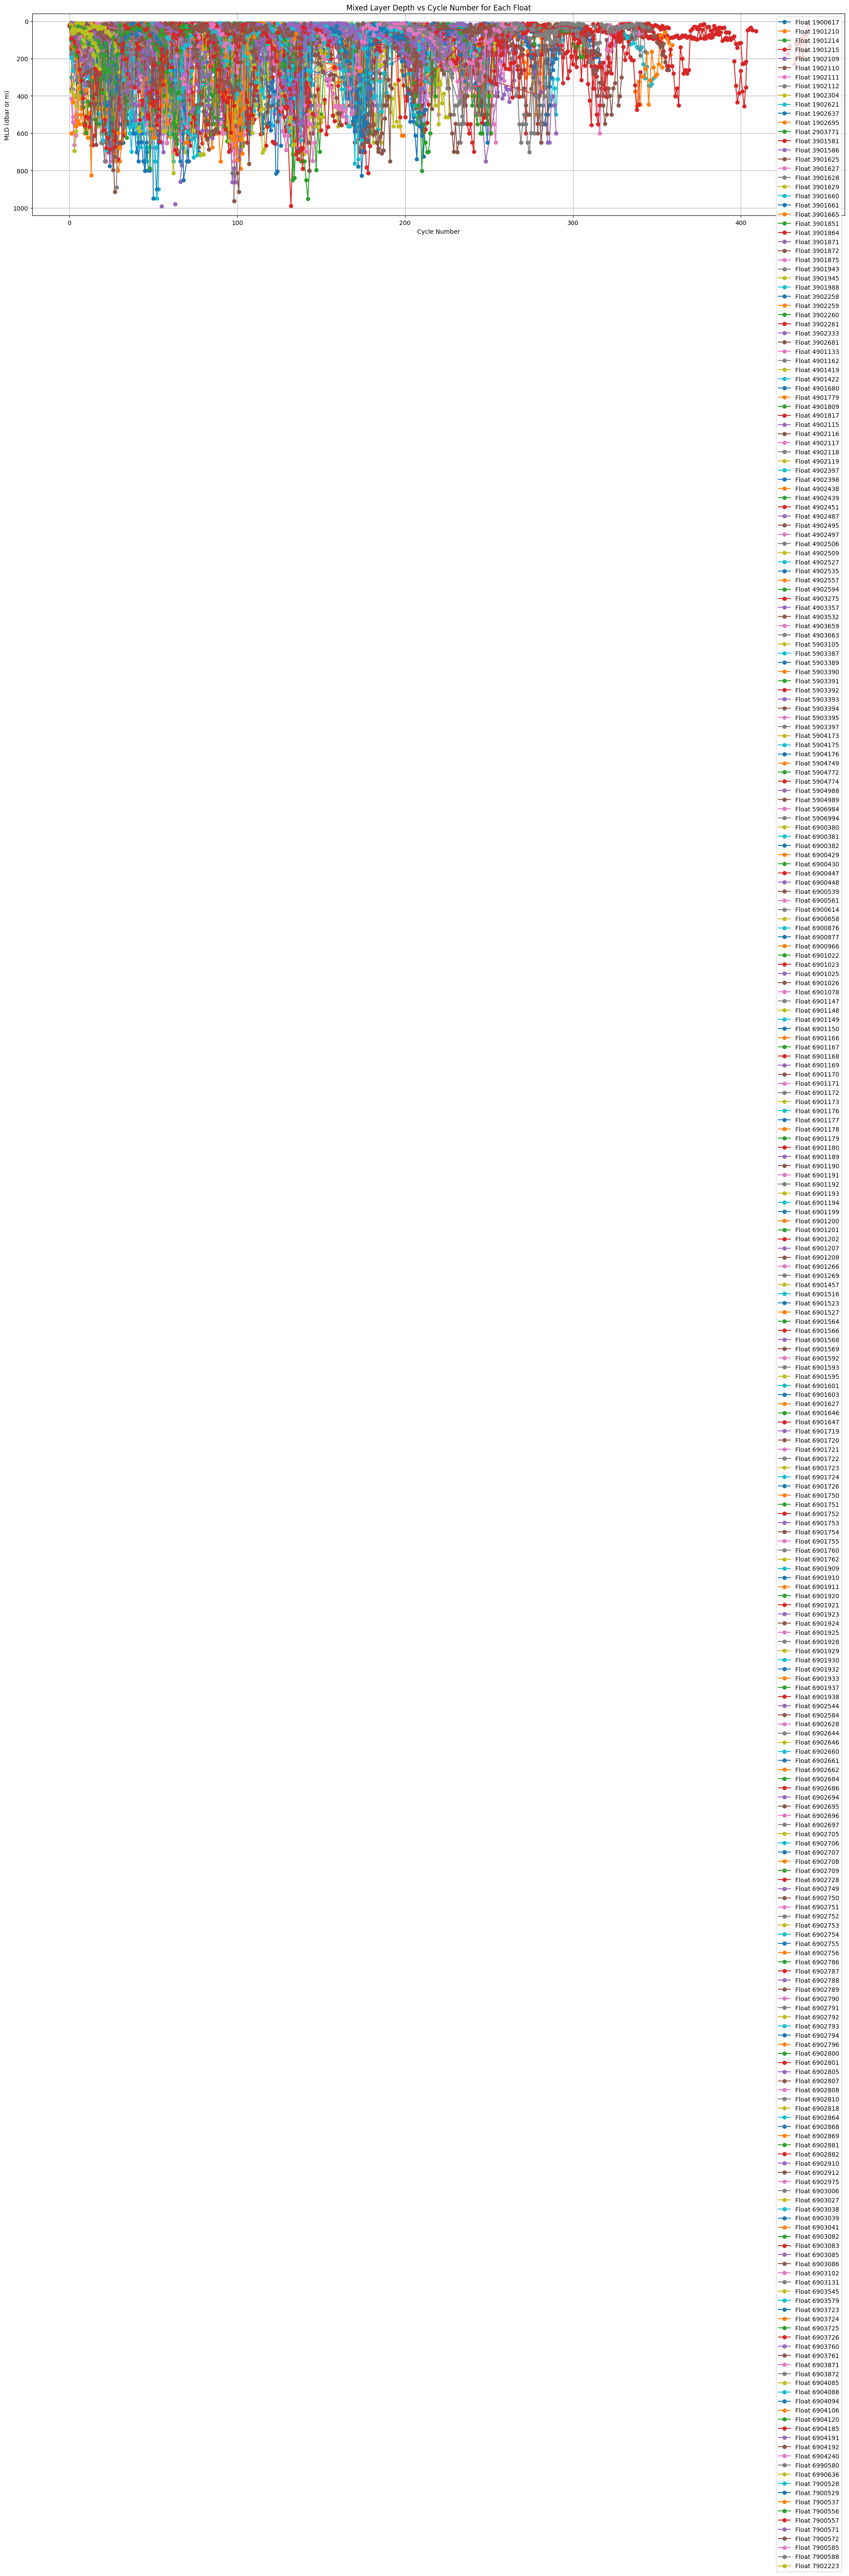

In [54]:
# Visualizing MLD data

cycle_summary = (df.
                 select("PLATFORM_NUMBER", "CYCLE_NUMBER", "MLD")
                 .unique()
                 .sort("PLATFORM_NUMBER", "CYCLE_NUMBER"))

summary_pd = cycle_summary.to_pandas()


fig, ax = plt.subplots(figsize=(24,6))
for float_id, sub in summary_pd.groupby("PLATFORM_NUMBER"):
    ax.plot(sub["CYCLE_NUMBER"], sub["MLD"],
            marker="o", label=f"Float {float_id}")

ax.set_xlabel("Cycle Number")
ax.set_ylabel("MLD (dbar or m)")
ax.set_title("Mixed Layer Depth vs Cycle Number for Each Float")
ax.invert_yaxis()  # optional: deeper = larger depth, so invert if you want shallow at top
ax.legend()
plt.grid(True)
plt.show()

# Excess code

In [36]:
import rasterio
import geopandas as gpd
import polars as pl
import numpy as np
import pandas as pd

In [37]:
# Loading Raster Path

raster_path = '../data/etopo1_subset.nc'
with rasterio.open(raster_path) as src:
    bathy = src.read(1)           # 2-D numpy Array of Depths
    transform = src.transform     # Affine (no clue ngl) transform for georeferencing (I am guessing it helps to map pixel coordinates to geographic coordinates)
    crs = src.crs                 # Coordinate system

mask = bathy > 1000

In [38]:
# 1) Load bathymetry (NetCDF)
import xarray as xr

ds = xr.open_dataset(raster_path)

# Typical var/coord names (adjust if yours differ)
# ETOPO1: variable can be 'z' (elevation, meters), longitude/latitude coords often 'longitude'/'latitude'
z = ds["z"]                             # elevation (m); oceans are NEGATIVE
lon = ds["longitude"].values            # 1D
lat = ds["latitude"].values             # 1D

# (Optional) convert lon from 0..360 → -180..180 if needed:
# lon = ((lon + 180) % 360) - 180

# 2) Build the lon/lat grid
LON, LAT = np.meshgrid(lon, lat)

# 3) Make the mask: 'deep ocean' (depth > 1000 m) means elevation <= -1000
Shape_deep = (z.values <= -1000)

# If z has land masked as NaN, turn NaNs into False
Shape_deep = np.where(np.isnan(z.values), False, Shape_deep)

In [39]:
Shape1 = np.full(LON.shape, True)

# Creating shapes to isolate basins

# Shape 1 Isolating the Ismingter Basin
lat_min = 56 + 0.8*(LON + 35)          # diagonal lower boundary

Shape1 = (
    (LON >= -35) & (LON <= -25) &      
    (LAT >= lat_min) &                 
    (LAT <= 66)                        
)


# Shape 2 (attempting) Isolating the Icelanding Basin 

# Domain longitudes for Shape2
lon_min, lon_max = -34.0, -10.0

# Upper boundary
lat_upper = np.where(
    LON <= -25,
    LON + 89.0,          # diagonal: (-34,55) -> (-25,64), slope = 1
    64.0                 # flat top from -25 to -10
)

# Lower boundary
lat_lower = np.where(
    LON <= -22,
    55.0,                # flat bottom from -34 to -22
    66.0 + 0.5*LON       # diagonal: (-22,55) -> (-10,61)
)

Shape2 = (
    (LON >= lon_min) & (LON <= lon_max) &
    (LAT >= lat_lower) &
    (LAT <= lat_upper)
)

#from mask_to_polygons import binary_mask_to_polygons, save_geojson, classify_points_parquet

# 1) Make polygons from your masks (tweak simplify_tol for smoother edges)
#gdf_shape1 = binary_mask_to_polygons(LON, LAT, Shape1, simplify_tol=0.02, dissolve=True)
#gdf_shape2 = binary_mask_to_polygons(LON, LAT, Shape2, simplify_tol=0.02, dissolve=True)

In [40]:
import numpy as np
import pandas as pd
import xarray as xr

# --- 0) config ---
raster_path = "../data/etopo1_subset.nc"
profiles_parquet = "../data/argo/Region/Regional_Argo_Tablet.parquet"          # <-- change if needed
out_parquet = "../data/argo/Region/profiles_with_regions.parquet"  # <-- change if needed
require_deep_ocean = True  # set True if you want to keep only z <= -1000 m

# --- 1) load ETOPO1 (optional, for deep-ocean mask) ---
ds = xr.open_dataset(raster_path)
# Common ETOPO1 names: z (meters), longitude, latitude
z_da = ds["z"]
lon_grid = ds["longitude"]
lat_grid = ds["latitude"]

# helper: normalize lon to [-180, 180]
def to_minus180_180(lon):
    lon = np.asarray(lon, dtype=float)
    return ((lon + 180.0) % 360.0) - 180.0

# --- 2) load your BGC profiles ---
df = pd.read_parquet(profiles_parquet)
# assume df has columns: 'longitude', 'latitude'
lonp = to_minus180_180(df["LONGITUDE"].values)
latp = df["LATITUDE"].values

# --- 3) define the two shapes as inequalities on points ---

# Shape 1: "Ismingter Basin" (using your formulas)
# bounds: -35 <= lon <= -25, lat_min <= lat <= 66, where
# lat_min = 56 + 0.8*(lon + 35)
lat_min_1 = 56.0 + 0.8*(lonp + 35.0)
in_shape1 = (lonp >= -35.0) & (lonp <= -25.0) & (latp >= lat_min_1) & (latp <= 66.0)

# Shape 2: "Icelanding Basin" (piecewise top/bottom)
# domain: -34 <= lon <= -10
# upper:
#   if lon <= -25: lat_upper = lon + 89
#   else:          lat_upper = 64
lat_upper_2 = np.where(lonp <= -25.0, lonp + 89.0, 64.0)
# lower:
#   if lon <= -22: lat_lower = 55
#   else:          lat_lower = 66 + 0.5*lon
lat_lower_2 = np.where(lonp <= -22.0, 55.0, 66.0 + 0.5*lonp)
in_shape2 = (lonp >= -34.0) & (lonp <= -10.0) & (latp >= lat_lower_2) & (latp <= lat_upper_2)

# --- 4) optional: enforce deep ocean (z <= -1000 m) at the profile points ---
if require_deep_ocean:
    # Build indexers for interpolation
    # Note: ETOPO1 often uses coords named exactly 'longitude'/'latitude'
    zi = z_da.interp(longitude=(["p"], lonp), latitude=(["p"], latp)).values
    deep = zi <= -1000.0
    in_shape1 &= deep
    in_shape2 &= deep

# --- 5) label rows ---
labels = np.full(len(df), "Other", dtype=object)
labels[in_shape1] = "shape1"
labels[in_shape2] = "shape2"

# If you want exactly-one region (shape2 overrides shape1 where they overlap),
# the above already does that due to evaluation order. If you want the reverse,
# assign shape2 first, then shape1.

df["region"] = labels

# (optional) if you want to keep only the two shapes:
# df = df[df["region"].isin(["shape1", "shape2"])].reset_index(drop=True)

# --- 6) save ---
df.to_parquet(out_parquet, index=False)
print(df["region"].value_counts(dropna=False))
print(f"Saved: {out_parquet}")
print(df["region"].value_counts())

region
Other    5493656
Name: count, dtype: int64
Saved: ../data/argo/Region/profiles_with_regions.parquet
region
Other    5493656
Name: count, dtype: int64


In [41]:
from rasterio.features import shapes
import shapely.geometry as geom
import geopandas as gpd

shapes_gen = shapes(mask.astype(np.uint8), mask=mask, transform=transform)

polygons = []


for geom_dict, value in shapes_gen:
    if value == 1:
        poly = geom.shape(geom_dict)    # shapely geometry
        polygons.append(poly)

gdf_polys = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

In [42]:
union_poly = gdf_polys.unary_union
gdf_union = gpd.GeoDataFrame({'geometry': [union_poly]}, crs=crs)
#gdf_union = gdf_union.simplify(tolerance=some_value)  # optional

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_6343/2081261486.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_poly = gdf_polys.unary_union
